In [1]:
# Get list of unique subjects from each EHR csv

from glob import glob
import pandas as pd
import pickle
mimic_iv_path = '/scratch/arz8448/capstone/data/mimic-iv'


try:
    with open('subjects.pkl', 'rb') as f:
        subjects = pickle.load(f)
    with open('csvs_skipped.pkl' ,'rb') as f:
        csvs_skipped = pickle.load(f)
except IOError:  
    csvs_skipped = []
    subjects = {}

    csv_files = glob(mimic_iv_path+'/**/*.csv', recursive=True)
    for csv in csv_files:
        if 'subject_id' in pd.read_csv(csv, nrows=0).columns:
            subjects[csv.split('/')[-2]+'/'+csv.split('/')[-1]] = pd.unique(pd.read_csv(csv, usecols=['subject_id'], low_memory=True).subject_id)
        else:
            csvs_skipped.append(csv.split('/')[-2]+'/'+csv.split('/')[-1])
        print(csv.split('/')[-1])
        
    with open('subjects.pkl', 'wb') as f:
        pickle.dump(subjects, f)
    with open('csvs_skipped.pkl', 'wb') as f:
        pickle.dump(csvs_skipped, f)


In [2]:
subjects

{'icu/procedureevents.csv': array([15693895, 12481680, 15614172, ..., 10682684, 13043521, 13575761]),
 'icu/datetimeevents.csv': array([10003700, 10004235, 10004720, ..., 19995244, 19997448, 19999068]),
 'icu/inputevents.csv': array([12481680, 15614172, 13441205, ..., 10682684, 13043521, 13575761]),
 'icu/outputevents.csv': array([10003700, 10004235, 10004720, ..., 19995244, 19997448, 19999068]),
 'icu/icustays.csv': array([17867402, 14435996, 17609946, ..., 15368898, 12275003, 17840864]),
 'icu/chartevents.csv': array([10003700, 10004235, 10004720, ..., 19995244, 19997448, 19999068]),
 'core/transfers.csv': array([14550633, 15216953, 15776555, ..., 16554479, 10636110, 13152507]),
 'core/admissions.csv': array([14679932, 15585972, 11989120, ..., 11084272, 14582634, 19389857]),
 'core/patients.csv': array([10000048, 10002723, 10003939, ..., 19999068, 19999270, 19999298]),
 'ed/triage.csv': array([15585360, 17192424, 15248757, ..., 18946033, 17526143, 11894181]),
 'ed/medrecon.csv': arra

In [3]:
csvs_skipped

['icu/d_items.csv',
 'hosp/d_icd_procedures.csv',
 'hosp/d_icd_diagnoses.csv',
 'hosp/d_hcpcs.csv',
 'hosp/d_labitems.csv']

In [4]:
# How many subjects appear in every csv file?
keys = [x for x in subjects.keys()]
appear_in_all = subjects[keys[0]]
for i in range(1,len(keys)):
    appear_in_all = list(set(appear_in_all) & set(subjects[keys[i]]))
len(appear_in_all)

7901

In [5]:
# CSV with most patients
max_key = max(subjects, key= lambda x: len(set(subjects[x])))
print(max_key)
len(subjects[max_key])

core/transfers.csv


382278

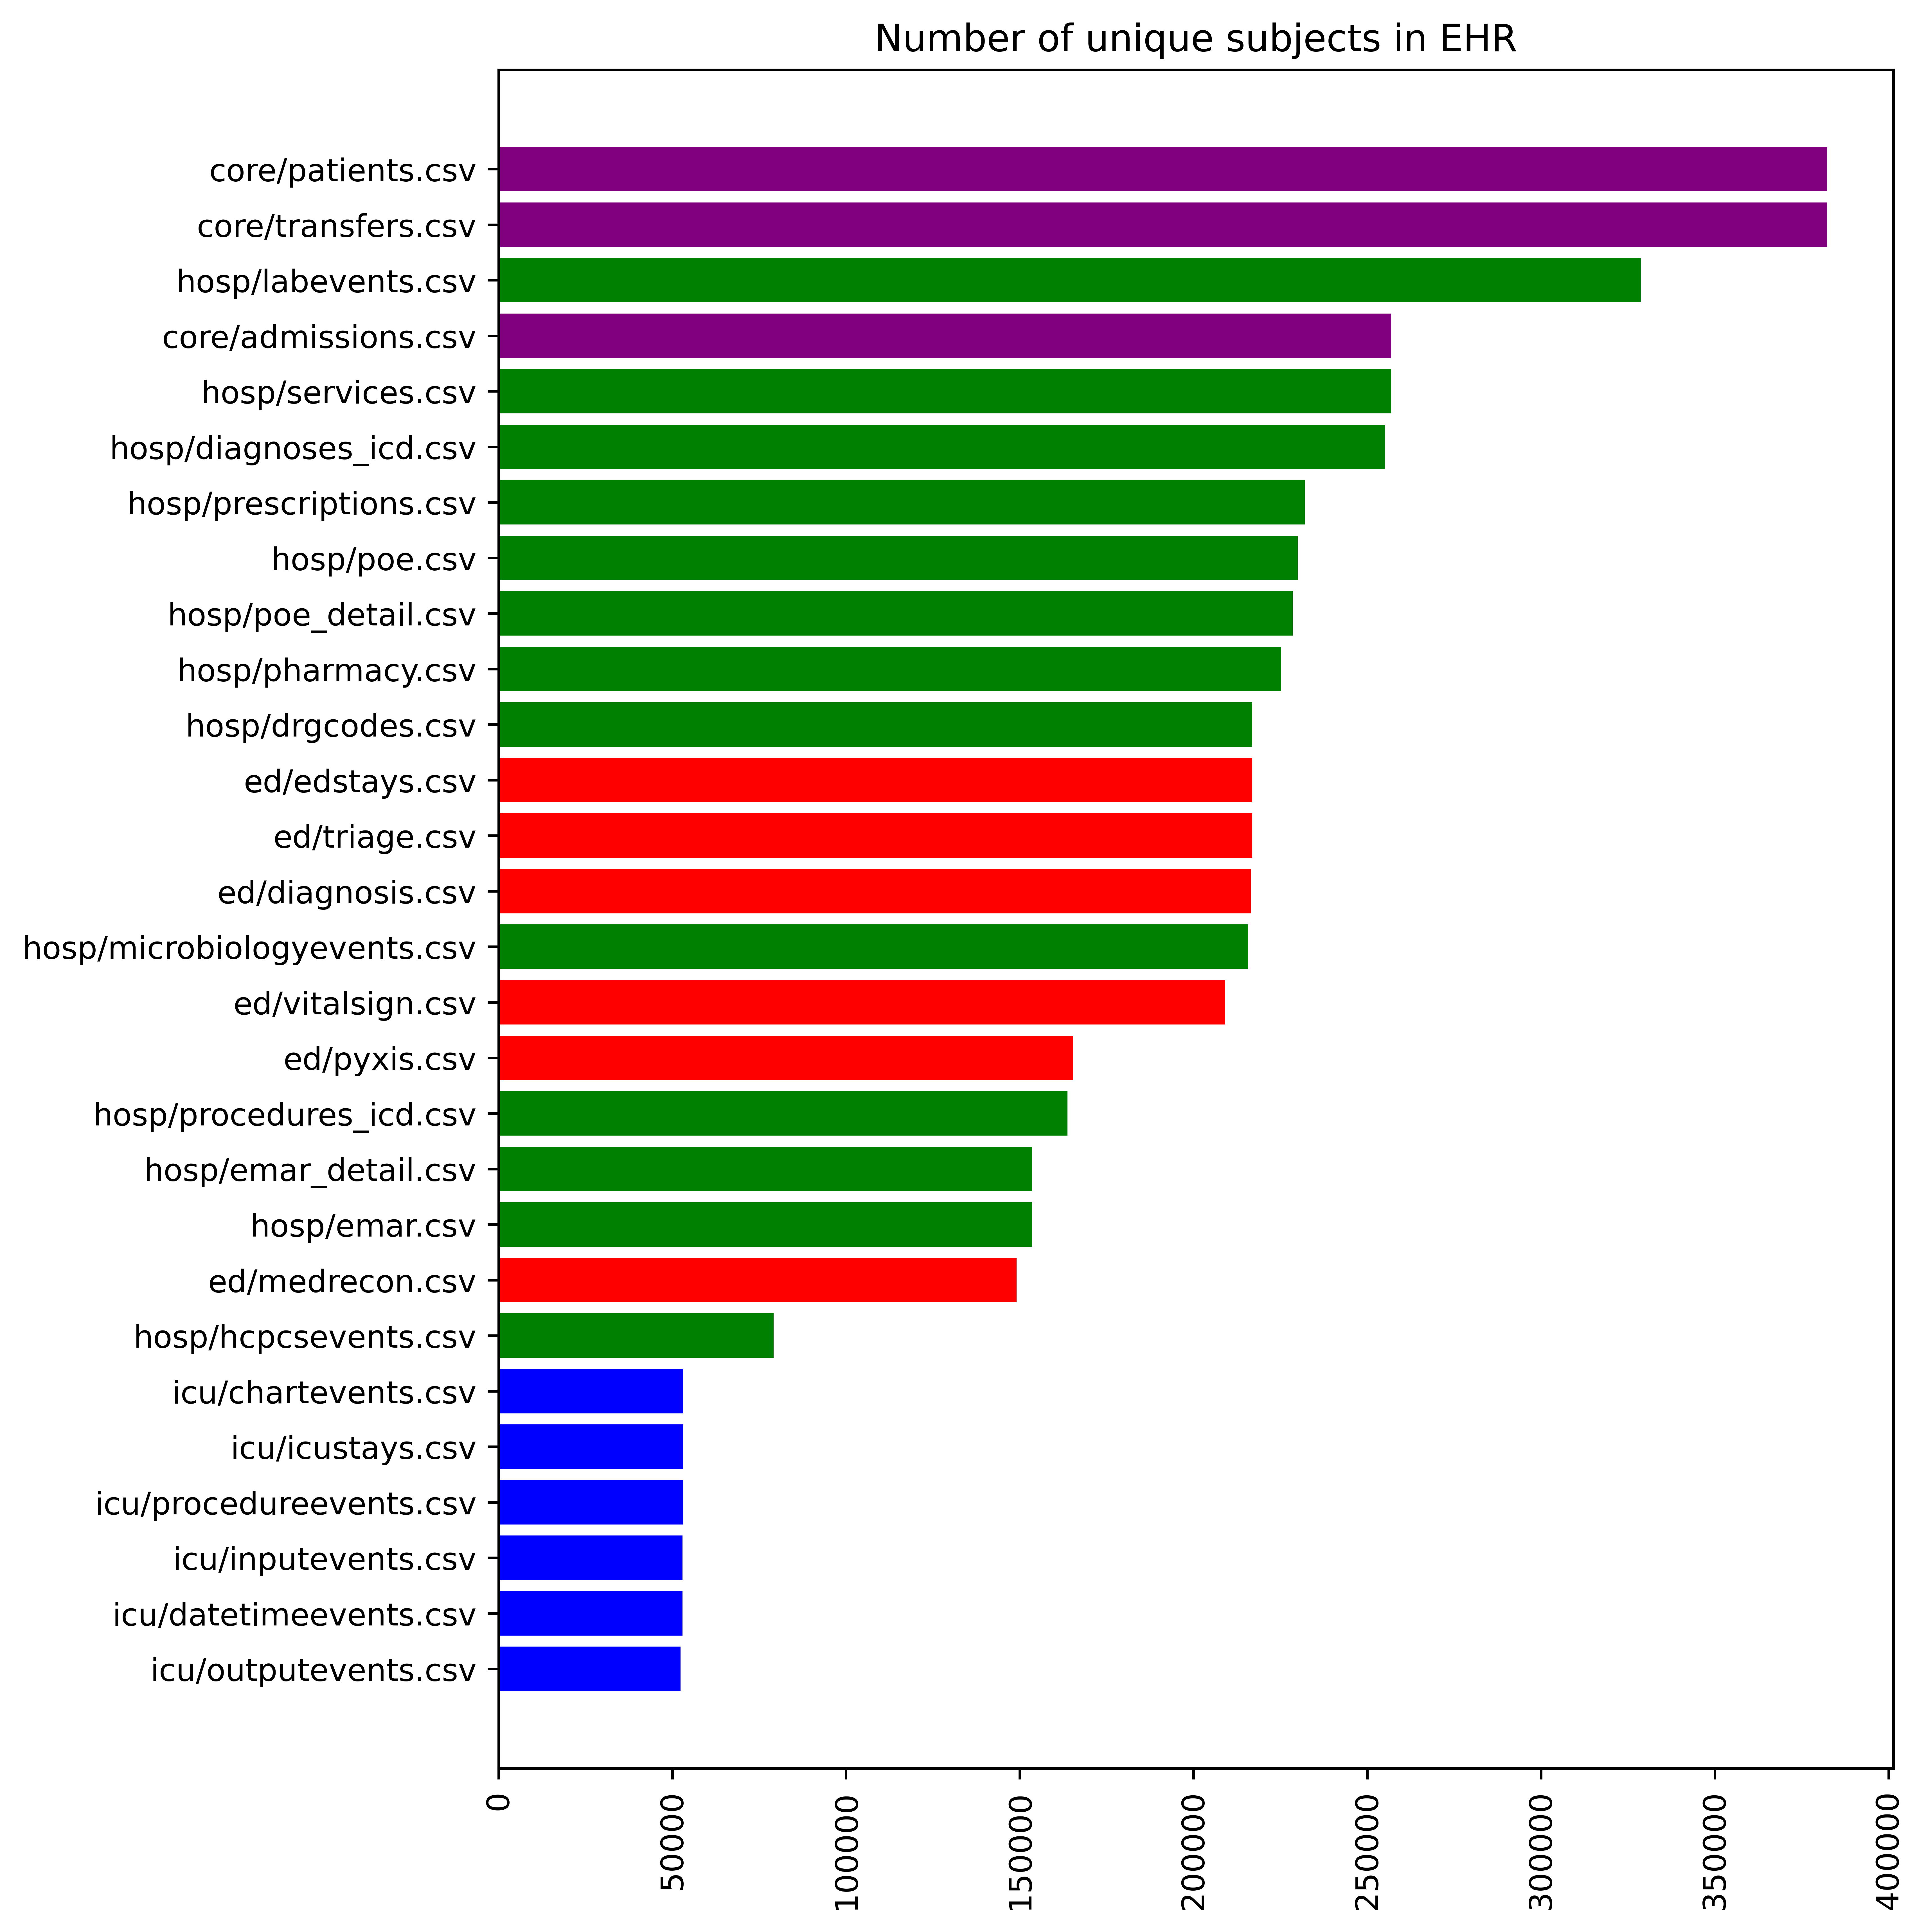

In [6]:
# Visualize subject count

import matplotlib.pyplot as plt
subject_count = {}
for key in subjects.keys():
    subject_count[key] = len(subjects[key])
    
sorted_count = sorted(subject_count.items(), key=lambda item: item[1])
colors = []
for x in [x for x,y in sorted_count]:
    label = x.split('/')[0]
    if 'ed' in label:
        colors.append('red')
    elif 'icu' in label:
        colors.append('blue')
    elif 'hosp' in label:
        colors.append('green')
    elif 'core' in label:
        colors.append('purple')
plt.figure(figsize=(8, 10), dpi=800)
plt.title('Number of unique subjects in EHR')
plt.barh([x for x,y in sorted_count], [y for x,y in sorted_count], color=colors)
plt.xticks(rotation = 90)
plt.show()

In [7]:
# Get subjects from CXR
mimic_cxr_path = '/scratch/arz8448/capstone/data/mimic-cxr-jpg'
mimic_cxr_subjects = pd.unique(pd.read_csv(mimic_cxr_path + '/mimic-cxr-2.0.0-metadata.csv', usecols=['subject_id']).subject_id)
print(mimic_cxr_subjects)
len(mimic_cxr_subjects)

[10000032 10000764 10000898 ... 19999442 19999733 19999987]


65379

In [8]:
# How many of CXR live in patients.csv?
len(list(set(subjects['core/patients.csv']) & set(mimic_cxr_subjects)))

65152

In [9]:
# CSV with most overlap?

most_overlap_key = max(subjects, key= lambda x: len(list(set(subjects[x]) & set(mimic_cxr_subjects))))
print(most_overlap_key)
len(list(set(subjects[most_overlap_key]) & set(mimic_cxr_subjects)))

core/transfers.csv


65152

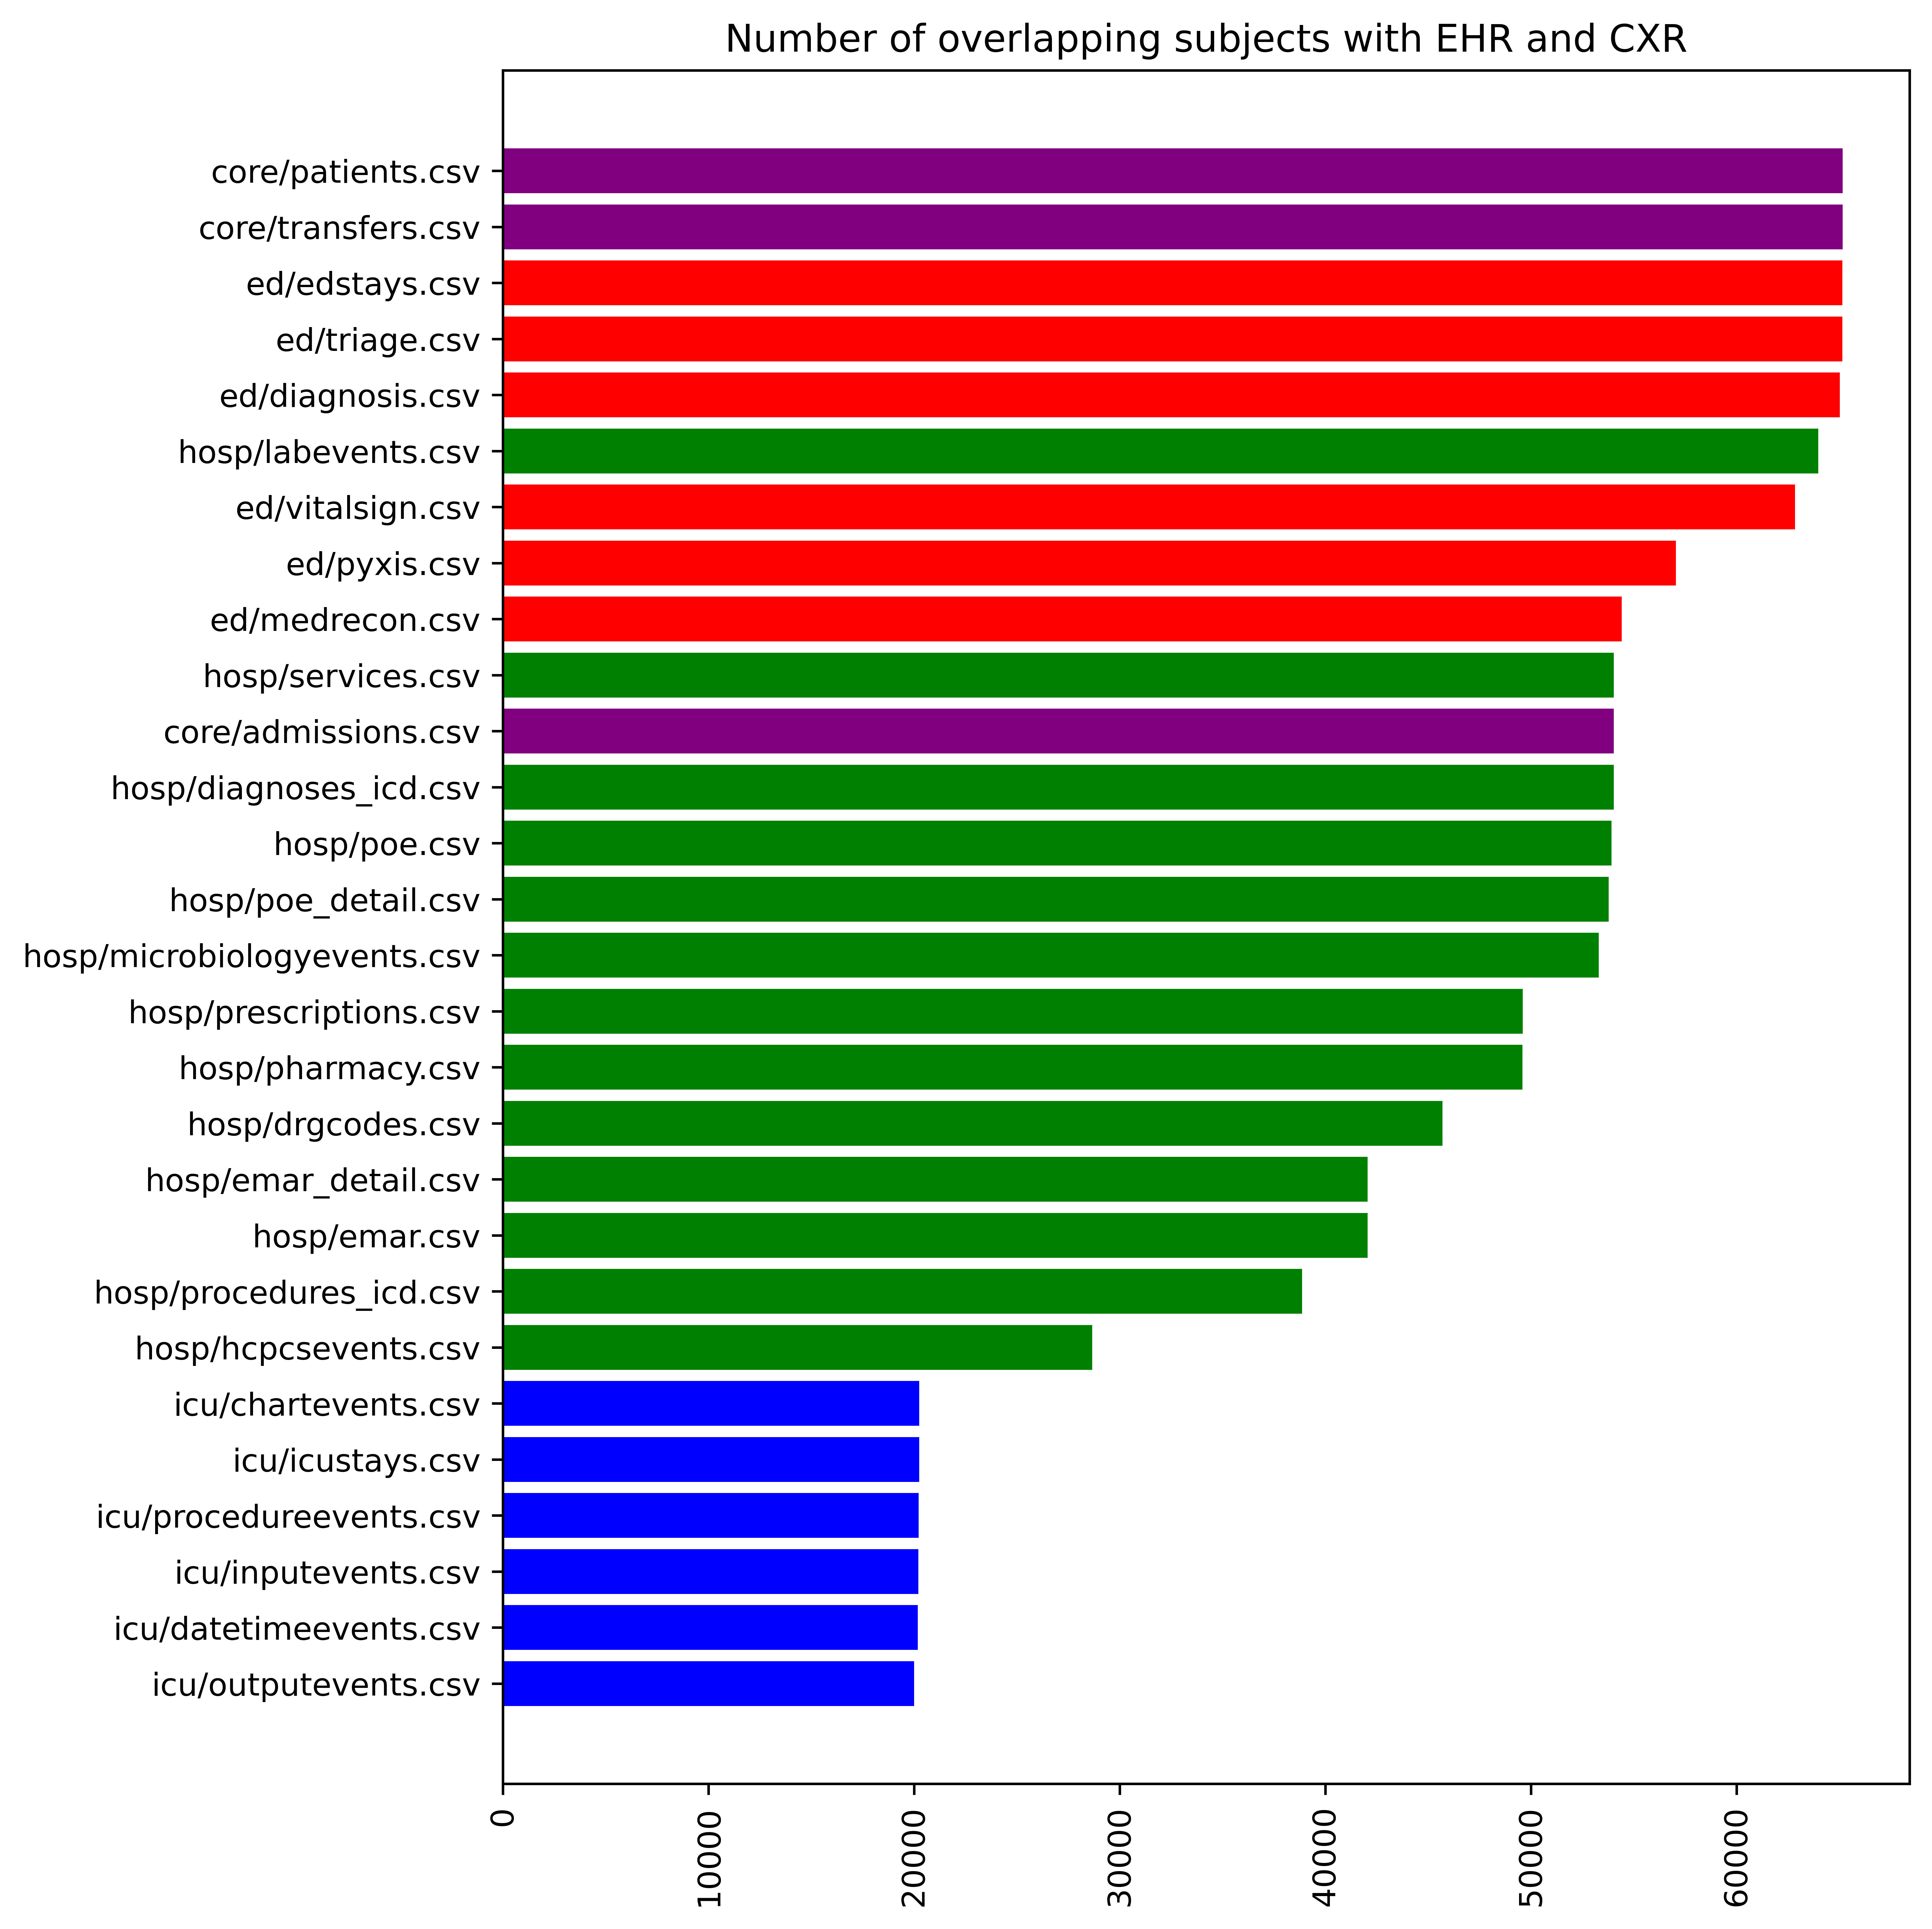

In [10]:
# Visualize overlap count

import matplotlib.pyplot as plt
overlap_count = {}
for key in subjects.keys():
    overlap_count[key] = len(list(set(subjects[key]) & set(mimic_cxr_subjects)))
    
sorted_overlap = sorted(overlap_count.items(), key=lambda item: item[1])
colors = []
for x in [x for x,y in sorted_overlap]:
    label = x.split('/')[0]
    if 'ed' in label:
        colors.append('red')
    elif 'icu' in label:
        colors.append('blue')
    elif 'hosp' in label:
        colors.append('green')
    elif 'core' in label:
        colors.append('purple')
plt.figure(figsize=(8, 10), dpi=800)
plt.title('Number of overlapping subjects with EHR and CXR')
plt.barh([x for x,y in sorted_overlap], [y for x,y in sorted_overlap], color=colors)
plt.xticks(rotation = 90)
plt.show()

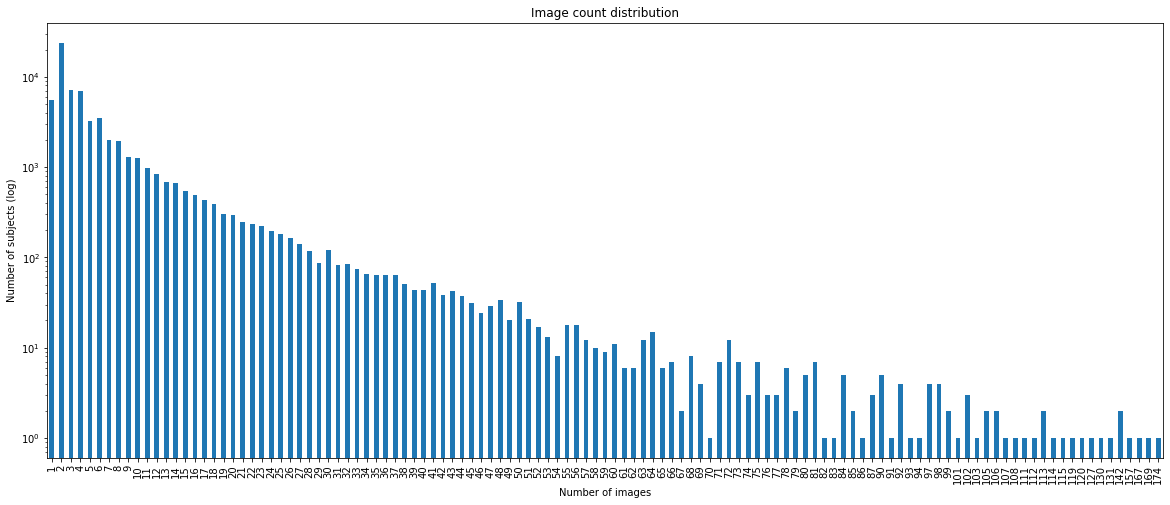

Mean of 5.77 images per patient
25% quantile: 2.0 images per patient
50% quantile: 3.0 images per patient
75% quantile: 6.0 images per patient


In [11]:
cxr_meta = pd.read_csv(mimic_cxr_path + '/mimic-cxr-2.0.0-metadata.csv')
vc = cxr_meta['subject_id'].value_counts()
vc.value_counts(sort=False)[::-1].plot(kind='bar',figsize=(20,8),logy=True,
                                       title='Image count distribution',
                                       xlabel='Number of images', 
                                       ylabel= 'Number of subjects (log)')
plt.show()

print(f'Mean of {vc.mean():1.2f} images per patient')
print(f'25% quantile: {vc.quantile(q=0.25)} images per patient')
print(f'50% quantile: {vc.quantile(q=0.50)} images per patient')
print(f'75% quantile: {vc.quantile(q=0.75)} images per patient')

In [12]:
# Moving onto text reports...
from sklearn.feature_extraction.text import CountVectorizer

try:
    with open('token_count.pkl', 'rb') as f:
        token_count = pickle.load(f)

except IOError:  
    
    files = glob(mimic_cxr_path+'/files/**/*.txt', recursive=True)
    token_count = {}
    for subject in [x.split('/')[-2][1:] for x in files]:
        token_count[subject] = []

    for file in files:
        with open (file, "r") as myfile:
            data=myfile.read().replace('\n', '')
            token_count[file.split('/')[-2][1:]].append(CountVectorizer().fit_transform([data]).shape[1])
            
    with open('token_count.pkl', 'wb') as f:
        pickle.dump(token_count, f)

In [13]:
token_count

{'16751112': [60],
 '16194043': [45],
 '16759428': [41, 90],
 '16011221': [70],
 '16658776': [47, 49, 38, 79, 49, 45, 49, 46, 57, 34, 45, 51],
 '16196998': [58, 67, 95, 89, 103, 63, 60, 43],
 '16364575': [43],
 '16551790': [54, 33, 46],
 '16808937': [57, 68, 59, 58, 49, 71, 87],
 '16307530': [54],
 '16748212': [73, 65, 60, 31, 65, 51, 75],
 '16371063': [52],
 '16549410': [78],
 '16977493': [47],
 '16589644': [49],
 '16486571': [38, 73, 43],
 '16560392': [68, 72, 46, 65, 98, 69],
 '16320616': [65, 65, 53, 79, 63, 109, 48, 49, 55, 82, 79, 59],
 '16677254': [38],
 '16610408': [118],
 '16207902': [44, 50, 76],
 '16275555': [129, 79, 77],
 '16317751': [39, 39],
 '16672854': [80, 59, 53, 61, 59, 62, 78, 43, 79, 67],
 '16336102': [46],
 '16176812': [54],
 '16819220': [80],
 '16073325': [91,
  53,
  87,
  49,
  63,
  52,
  69,
  67,
  49,
  54,
  50,
  95,
  78,
  83,
  89,
  92,
  60,
  64,
  49],
 '16969625': [56, 66, 60],
 '16884274': [74],
 '16131554': [62, 59],
 '16912501': [99],
 '167337

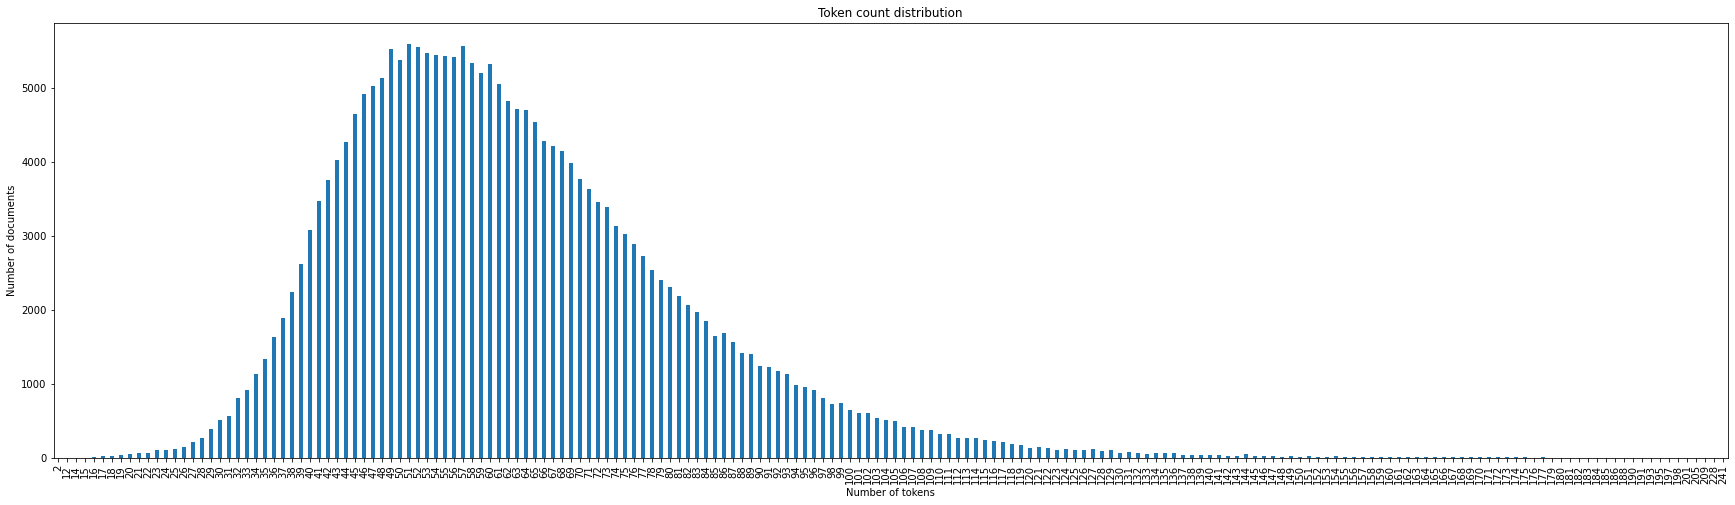

Mean of 62.52 tokens
25% quantile: 49.0 tokens
50% quantile: 60.0 tokens
75% quantile: 73.0 tokens
4 records have fewer than 15 tokens.


In [14]:
# Plot overall token count distribution
all_token_counts = []
all_token_counts.extend(token_count.values())
all_token_counts = [item for sublist in all_token_counts for item in sublist]

atc_series = pd.Series(all_token_counts)

atc_series.value_counts(sort=False).sort_index().plot(kind='bar',figsize=(30,8), title='Token count distribution', xlabel='Number of tokens', ylabel= 'Number of documents')
plt.show()

print(f'Mean of {atc_series.mean():1.2f} tokens')
print(f'25% quantile: {atc_series.quantile(q=0.25)} tokens')
print(f'50% quantile: {atc_series.quantile(q=0.50)} tokens')
print(f'75% quantile: {atc_series.quantile(q=0.75)} tokens')
print(f'{atc_series[atc_series < 15].count()} records have fewer than 15 tokens.')

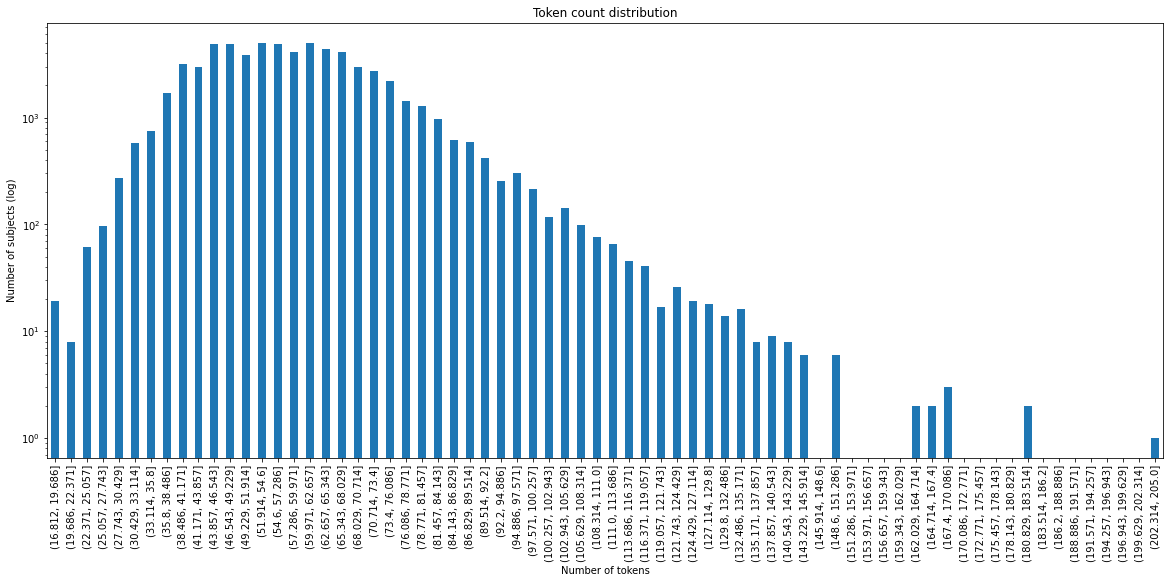

Mean of 58.45 average tokens per subject
25% quantile: 48.0 average tokens per subject
50% quantile: 57.0 average tokens per subject
75% quantile: 67.0 average tokens per subject
Minimum average tokens per subject: 17.0


In [15]:
# Plot mean token count per subject
mean_token_counts = list(map(lambda x: sum(token_count[x])/len(token_count[x]), token_count))

mtc_series = pd.Series(mean_token_counts)

pd.cut(mean_token_counts,70).value_counts().sort_index().plot(kind='bar',figsize=(20,8), logy=True,
                                                      title='Token count distribution',
                                                      xlabel='Number of tokens', 
                                                      ylabel= 'Number of subjects (log)')
plt.show()

print(f'Mean of {mtc_series.mean():1.2f} average tokens per subject')
print(f'25% quantile: {mtc_series.quantile(q=0.25)} average tokens per subject')
print(f'50% quantile: {mtc_series.quantile(q=0.50)} average tokens per subject')
print(f'75% quantile: {mtc_series.quantile(q=0.75)} average tokens per subject')
print(f'Minimum average tokens per subject: {mtc_series.min()}')

In [16]:
### Everything here and under is for 10/15 ###

In [17]:
# Dumb way to measure readmission
admissions = pd.read_csv(mimic_iv_path + '/core/admissions.csv')
admissions_pts = pd.unique(admissions.subject_id)

overlap_pts = list(set(admissions_pts) & set(mimic_cxr_subjects))
print(f'{len(overlap_pts)} overlapping patients between admissions and MIMIC-CXR.')

readmission = 0
for patient in overlap_pts:
    if len(admissions[admissions.subject_id == patient]) > 1:
        readmission += 1
        
print(f'{readmission} patients have readmission out of the overlapping patients.')

# How many died out of overlapping?
mort_pts = pd.unique(admissions[admissions.deathtime.notna()].subject_id)
overlap_mort_pts = list(set(mort_pts) & set(mimic_cxr_subjects))
print(f'{len(overlap_mort_pts)} patients have died out of the overlapping patients.')

54032 overlapping patients between admissions and MIMIC-CXR.
34766 patients have readmission out of the overlapping patients.
3775 patients have died out of the overlapping patients.


In [18]:
### Everything here and under for 10/22 ###
# 1. Find out which variables occur before scan (and get numbers of patients with each)
# 2. Get overlap between ICU and ED
# 3. Out of patients that died, how many were in ICU? in ED?

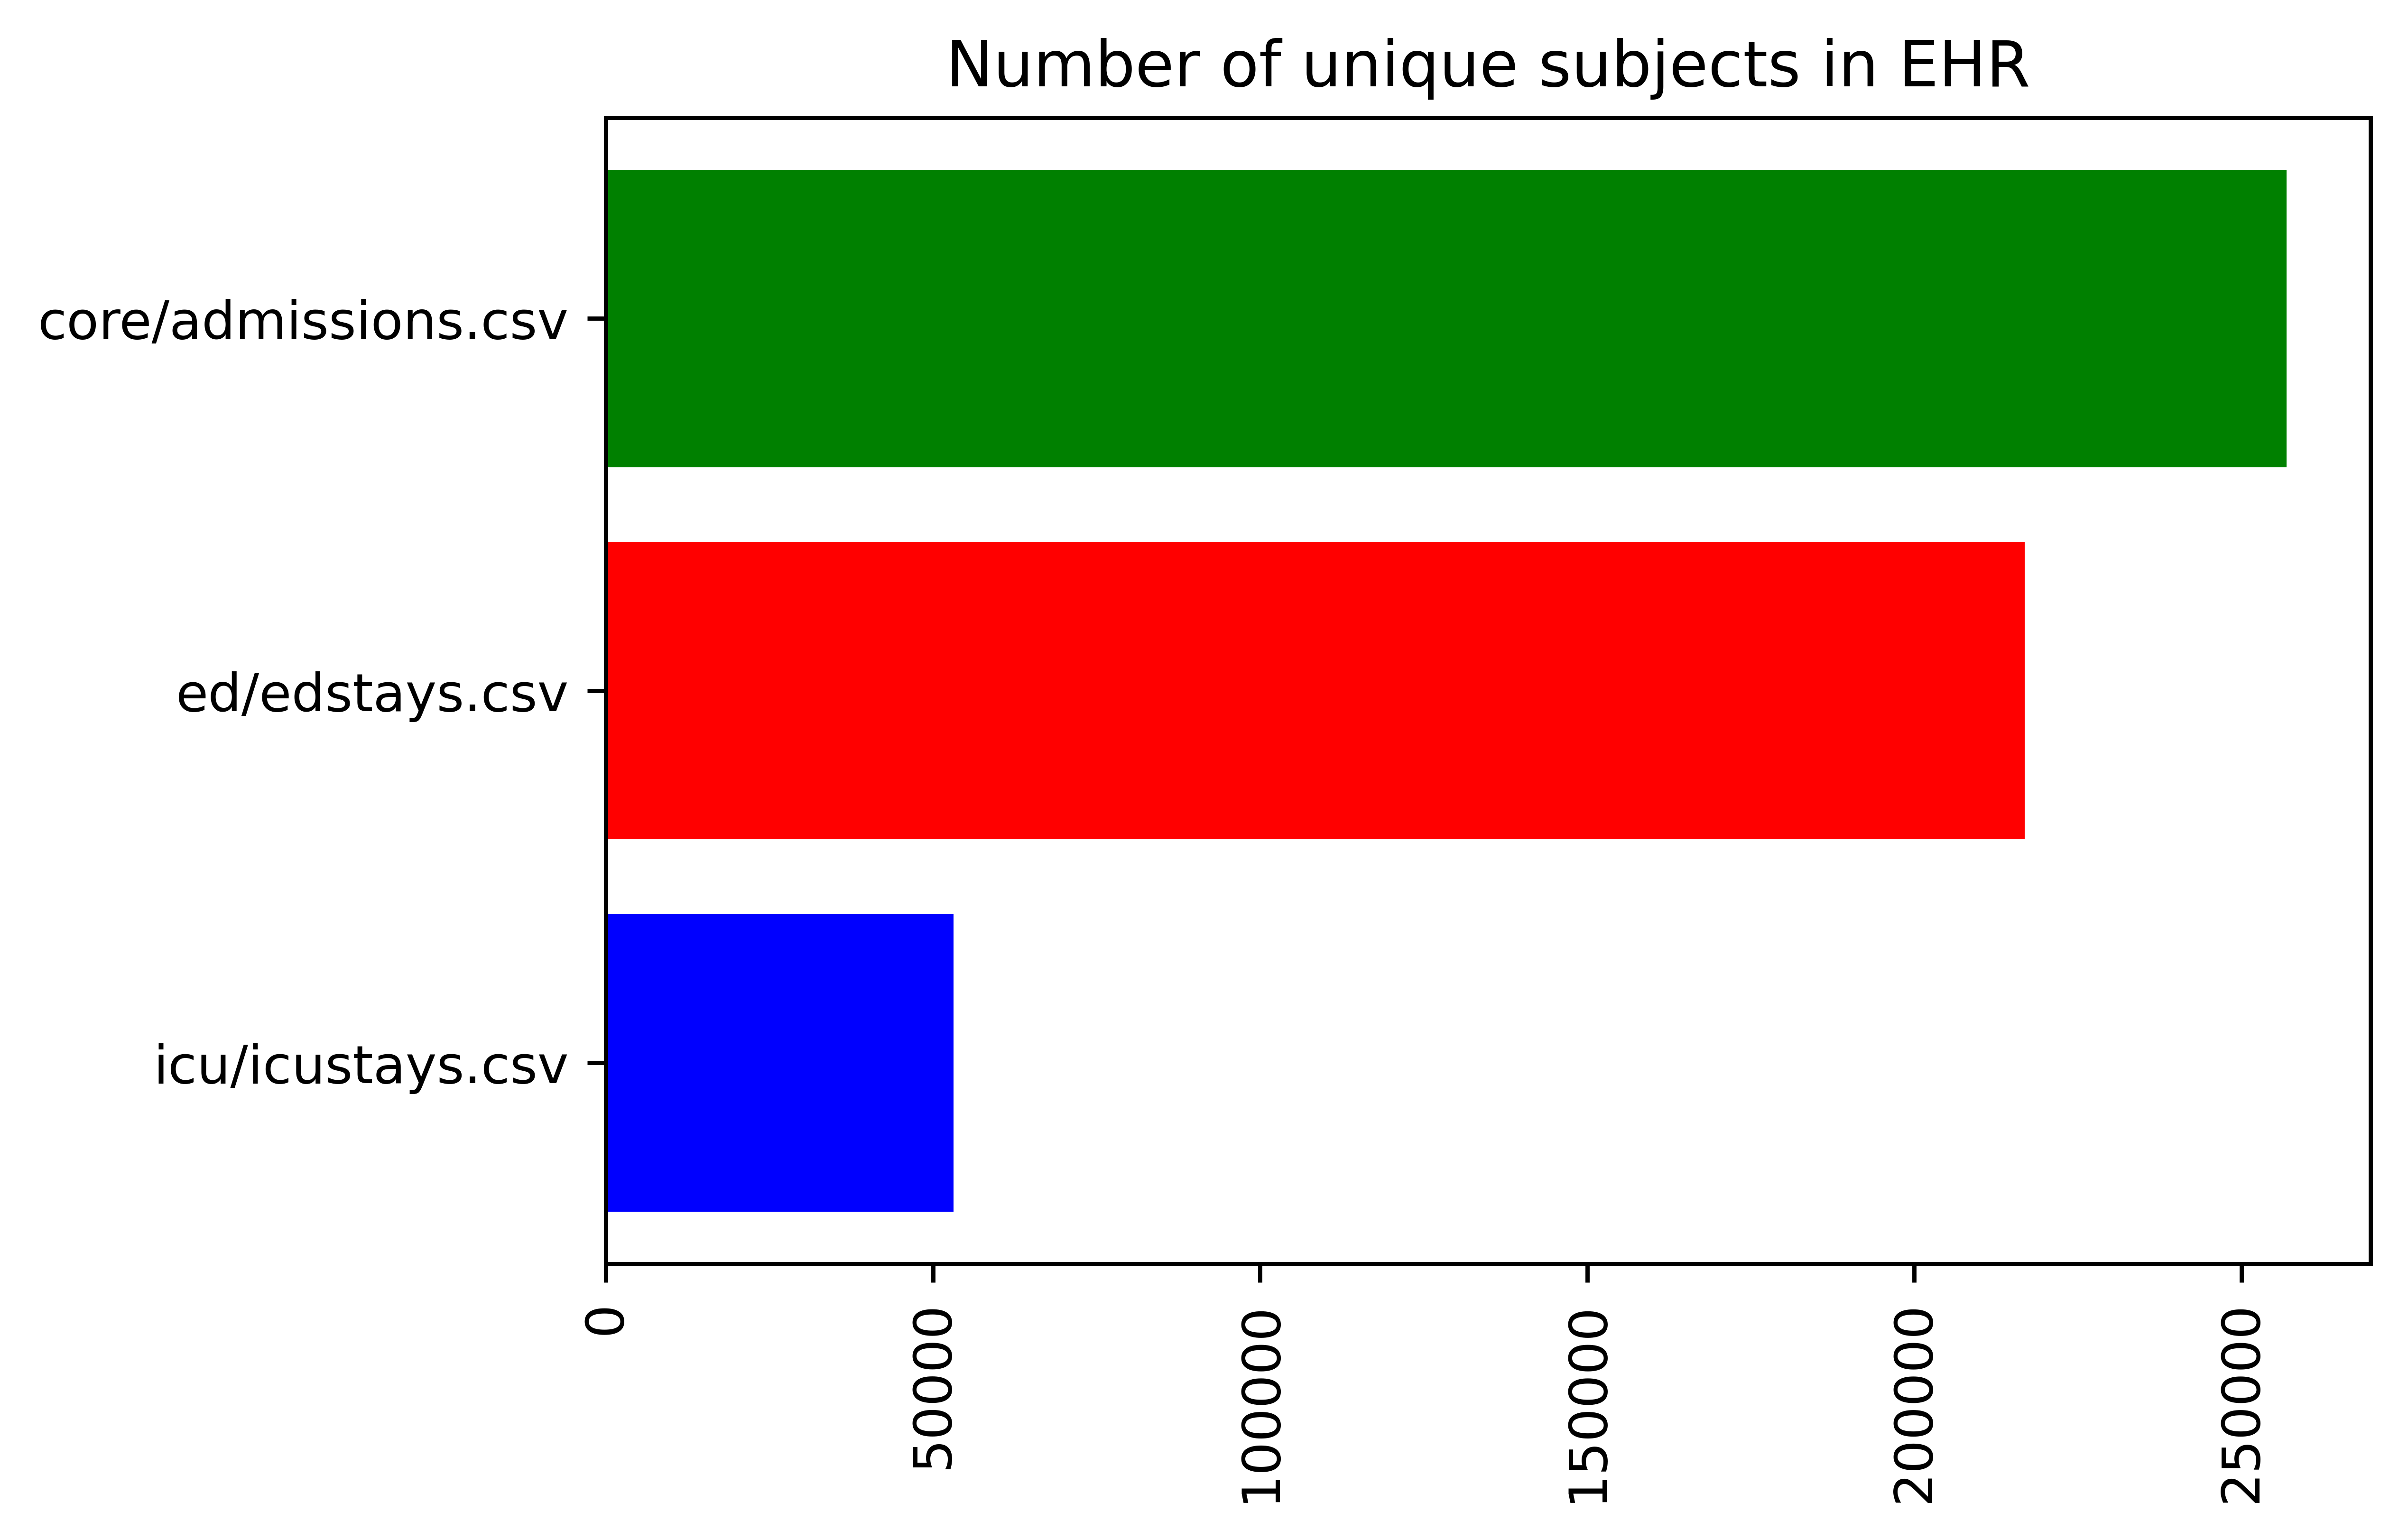

There are 33228 overlapping patients between ICU and ED.
20243 of those patients (60.92%) have CXR data.


In [19]:
# 2 first -- Get overlap between ICU and ED
# Visualize subject count

core_count = 'core/admissions.csv'
icu_count = 'icu/icustays.csv'
ed_count = 'ed/edstays.csv'

plt.figure(dpi=800)
plt.title('Number of unique subjects in EHR')
plt.barh(icu_count, subject_count[icu_count],color=  'blue')
plt.barh(ed_count, subject_count[ed_count], color= 'red')
plt.barh(core_count, subject_count[core_count], color= 'green')
plt.xticks(rotation = 90)
plt.show()

icu_and_ed = len(list(set(subjects['icu/icustays.csv']) & set(subjects['ed/edstays.csv'])))
print(f'There are {icu_and_ed} overlapping patients between ICU and ED.')
cxr_icu_ed = len(list(set(subjects['icu/icustays.csv']) & set(subjects['ed/edstays.csv']) & set(mimic_cxr_subjects)))
print(f'{cxr_icu_ed} of those patients ({cxr_icu_ed/icu_and_ed*100:1.2f}%) have CXR data.')

In [20]:
# 3 next -- Out of patients that died, how many were in ICU? in ED?
icu_mort_pts = list(set(mort_pts) & set(subjects['icu/icustays.csv']))
ed_mort_pts = list(set(mort_pts) & set(subjects['ed/edstays.csv']))
icu_cxr_mort = len(list(set(mort_pts) & set(subjects['icu/icustays.csv']) & set(mimic_cxr_subjects)))
ed_cxr_mort = len(list(set(mort_pts) & set(subjects['ed/edstays.csv']) & set(mimic_cxr_subjects)))
print(f'{len(mort_pts)} patients have died.')
print(f'{len(icu_mort_pts)} ({len(icu_mort_pts)/len(mort_pts)*100:1.2f}%) of those patients stayed in ICU.')
print(f'{len(ed_mort_pts)} ({len(ed_mort_pts)/len(mort_pts)*100:1.2f}%) of those patients stayed in ED.')
print(f'{len(overlap_mort_pts)} ({len(overlap_mort_pts)/len(mort_pts)*100:1.2f}%) have CXR.')
print(f'\nOut of {len(overlap_mort_pts)} patients with CXR, {icu_cxr_mort} of those patients stayed in ICU, and {ed_cxr_mort} in ED.')

9331 patients have died.
7826 (83.87%) of those patients stayed in ICU.
5485 (58.78%) of those patients stayed in ED.
3775 (40.46%) have CXR.

Out of 3775 patients with CXR, 3370 of those patients stayed in ICU, and 3775 in ED.


In [45]:
#1 last -- Find out which variables occur before scan (and get numbers of patients with each)

# Potnetial csvs of interst with timestamps = 
# hosp/emar,hcpcsevents,labevents,microbiologyevents,prescriptions,procedures_icd
# icu/chartevents,datetimeevents,inputevents,outputevents,procedureevents
# ed/medrecon,pyxis,edstays(intime for triage),vitalsign

# charttime with same format yyyy-mm-dd hh:mm:ss
# emar,labevents,microbiologyevents,chartevents,datetimeevents,outputevents,medrecon,pyxis,vitalsign
# starttime with same format yyyy-mm-dd hh:mm:ss
# prescriptions,inputevents,procedureevents
# intime with same format yyyy-mm-dd hh:mm:ss
# edstays
# chartdate with yyyy-mm-dd
# hcpcsevents,procedures_icd

# Operation: 
# 1. Get first/last cxr scan time per subject in mimic-cxr
# 2. For each csv, for each overlapping subject, check if a row has a timestamp < first/last scan
# 3. If so, subject_count++ (only once per subject), row_count ++ (to see how many rows per subject we have on avg)
# 4. Save row_count, reset to 0, and loop.
#import time
#from pandarallel import pandarallel as pl
import os
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

try:
    with open('time_check.pkl', 'rb') as f:
        time_check = pickle.load(f)
except IOError:
    # Op 1:
    cxr_meta =pd.read_csv(mimic_cxr_path + '/mimic-cxr-2.0.0-metadata.csv',
                    usecols=['subject_id', 'StudyDate','StudyTime'])
    study_date = cxr_meta.StudyDate.apply(lambda x: str(x))
    study_time = cxr_meta.StudyTime.apply(lambda x: str(x) if str(x).find('.') == 6 else str('0') + str(x))
    cxr_time = (study_date + study_time).apply(lambda x: float(x))
    cxr_time_df = pd.DataFrame({'subject_id': cxr_meta.subject_id, 'cxr_time': cxr_time})
    first_scan_times = cxr_time_df.groupby('subject_id').min()
    last_scan_times = cxr_time_df.groupby('subject_id').max()

    # Op 2-4:
    def strip_function_1(x):
        return int(''.join(filter(str.isdigit, x)))
    def strip_function_2(x):
        return int(''.join(filter(str.isdigit, x)) + '000000')
    hosp = ['emar','hcpcsevents','labevents','microbiologyevents','prescriptions','procedures_icd']
    icu = ['chartevents','datetimeevents','inputevents','outputevents','procedureevents']
    ed = ['medrecon','pyxis','edstays','vitalsign']
    csvs = ['hosp/' + x + '.csv' for x  in hosp] + ['icu/' + x + '.csv' for x  in icu] + ['ed/' + x + '.csv' for x  in ed]
    time_check = {}
    #pb = ProgressBar()
    #pb.register()
    #pb.unregister()
    #pl.initialize(nb_workers = len(os.sched_getaffinity(0)))
    for csv in csvs:
        csv_dict = {}
        try:
            df = dd.read_csv(mimic_iv_path+'/'+csv, usecols=['subject_id','charttime'])
        except ValueError:
            try:
                df = dd.read_csv(mimic_iv_path+'/'+csv, usecols=['subject_id','starttime'])
            except ValueError:
                try:
                    df = dd.read_csv(mimic_iv_path+'/'+csv, usecols=['subject_id','chartdate'])
                except ValueError:
                    df = dd.read_csv(mimic_iv_path+'/'+csv, usecols=['subject_id','intime'])

        
        df.columns = ['subject_id','time']
        df = df[df.time.notnull()]
        df = df.merge(first_scan_times,'left',left_on='subject_id',right_index=True)
        df = df.merge(last_scan_times,'left',left_on='subject_id',right_index=True,suffixes=('_first','_last'))

        
        df = df[df.cxr_time_first.notnull()] #Truncate first to reduce memory load
        df = df[df.cxr_time_last.notnull()]
        if csv in ['hosp/hcpcsevents.csv','hosp/procedures_icd.csv']:
            #df.time = df.time.parallel_apply(strip_function_2)
            df.time = df.time.apply(strip_function_2,1,meta=pd.Series(dtype='int', name='time'))
        else:
            #df.time = df.time.parallel_apply(strip_function_1)
            df.time = df.time.apply(strip_function_1,1,meta=pd.Series(dtype='int', name='time'))
        

        df['first_check'] = df.time < df.cxr_time_first
        df['last_check'] = df.time < df.cxr_time_last
    
        df = df.compute()
        first_scan_subject_count = len(pd.unique(df.subject_id[df.first_check]))
        last_scan_subject_count = len(pd.unique(df.subject_id[df.last_check]))
        csv_dict['overlapping_subject_count_first_scan'] = first_scan_subject_count
        csv_dict['mean_data_points_per_patient_first_scan'] = sum(df.first_check) / first_scan_subject_count
        csv_dict['overlapping_subject_count_last_scan'] = last_scan_subject_count
        csv_dict['mean_data_points_per_patient_last_scan'] = sum(df.last_check) / last_scan_subject_count
        time_check[csv] = csv_dict
        print(csv)
    with open('time_check.pkl', 'wb') as f:
            pickle.dump(time_check, f)

hosp/emar.csv
hosp/hcpcsevents.csv
hosp/labevents.csv
hosp/microbiologyevents.csv
hosp/prescriptions.csv
hosp/procedures_icd.csv
icu/chartevents.csv
icu/datetimeevents.csv
icu/inputevents.csv
icu/outputevents.csv
icu/procedureevents.csv
ed/medrecon.csv
ed/pyxis.csv
ed/edstays.csv
ed/vitalsign.csv


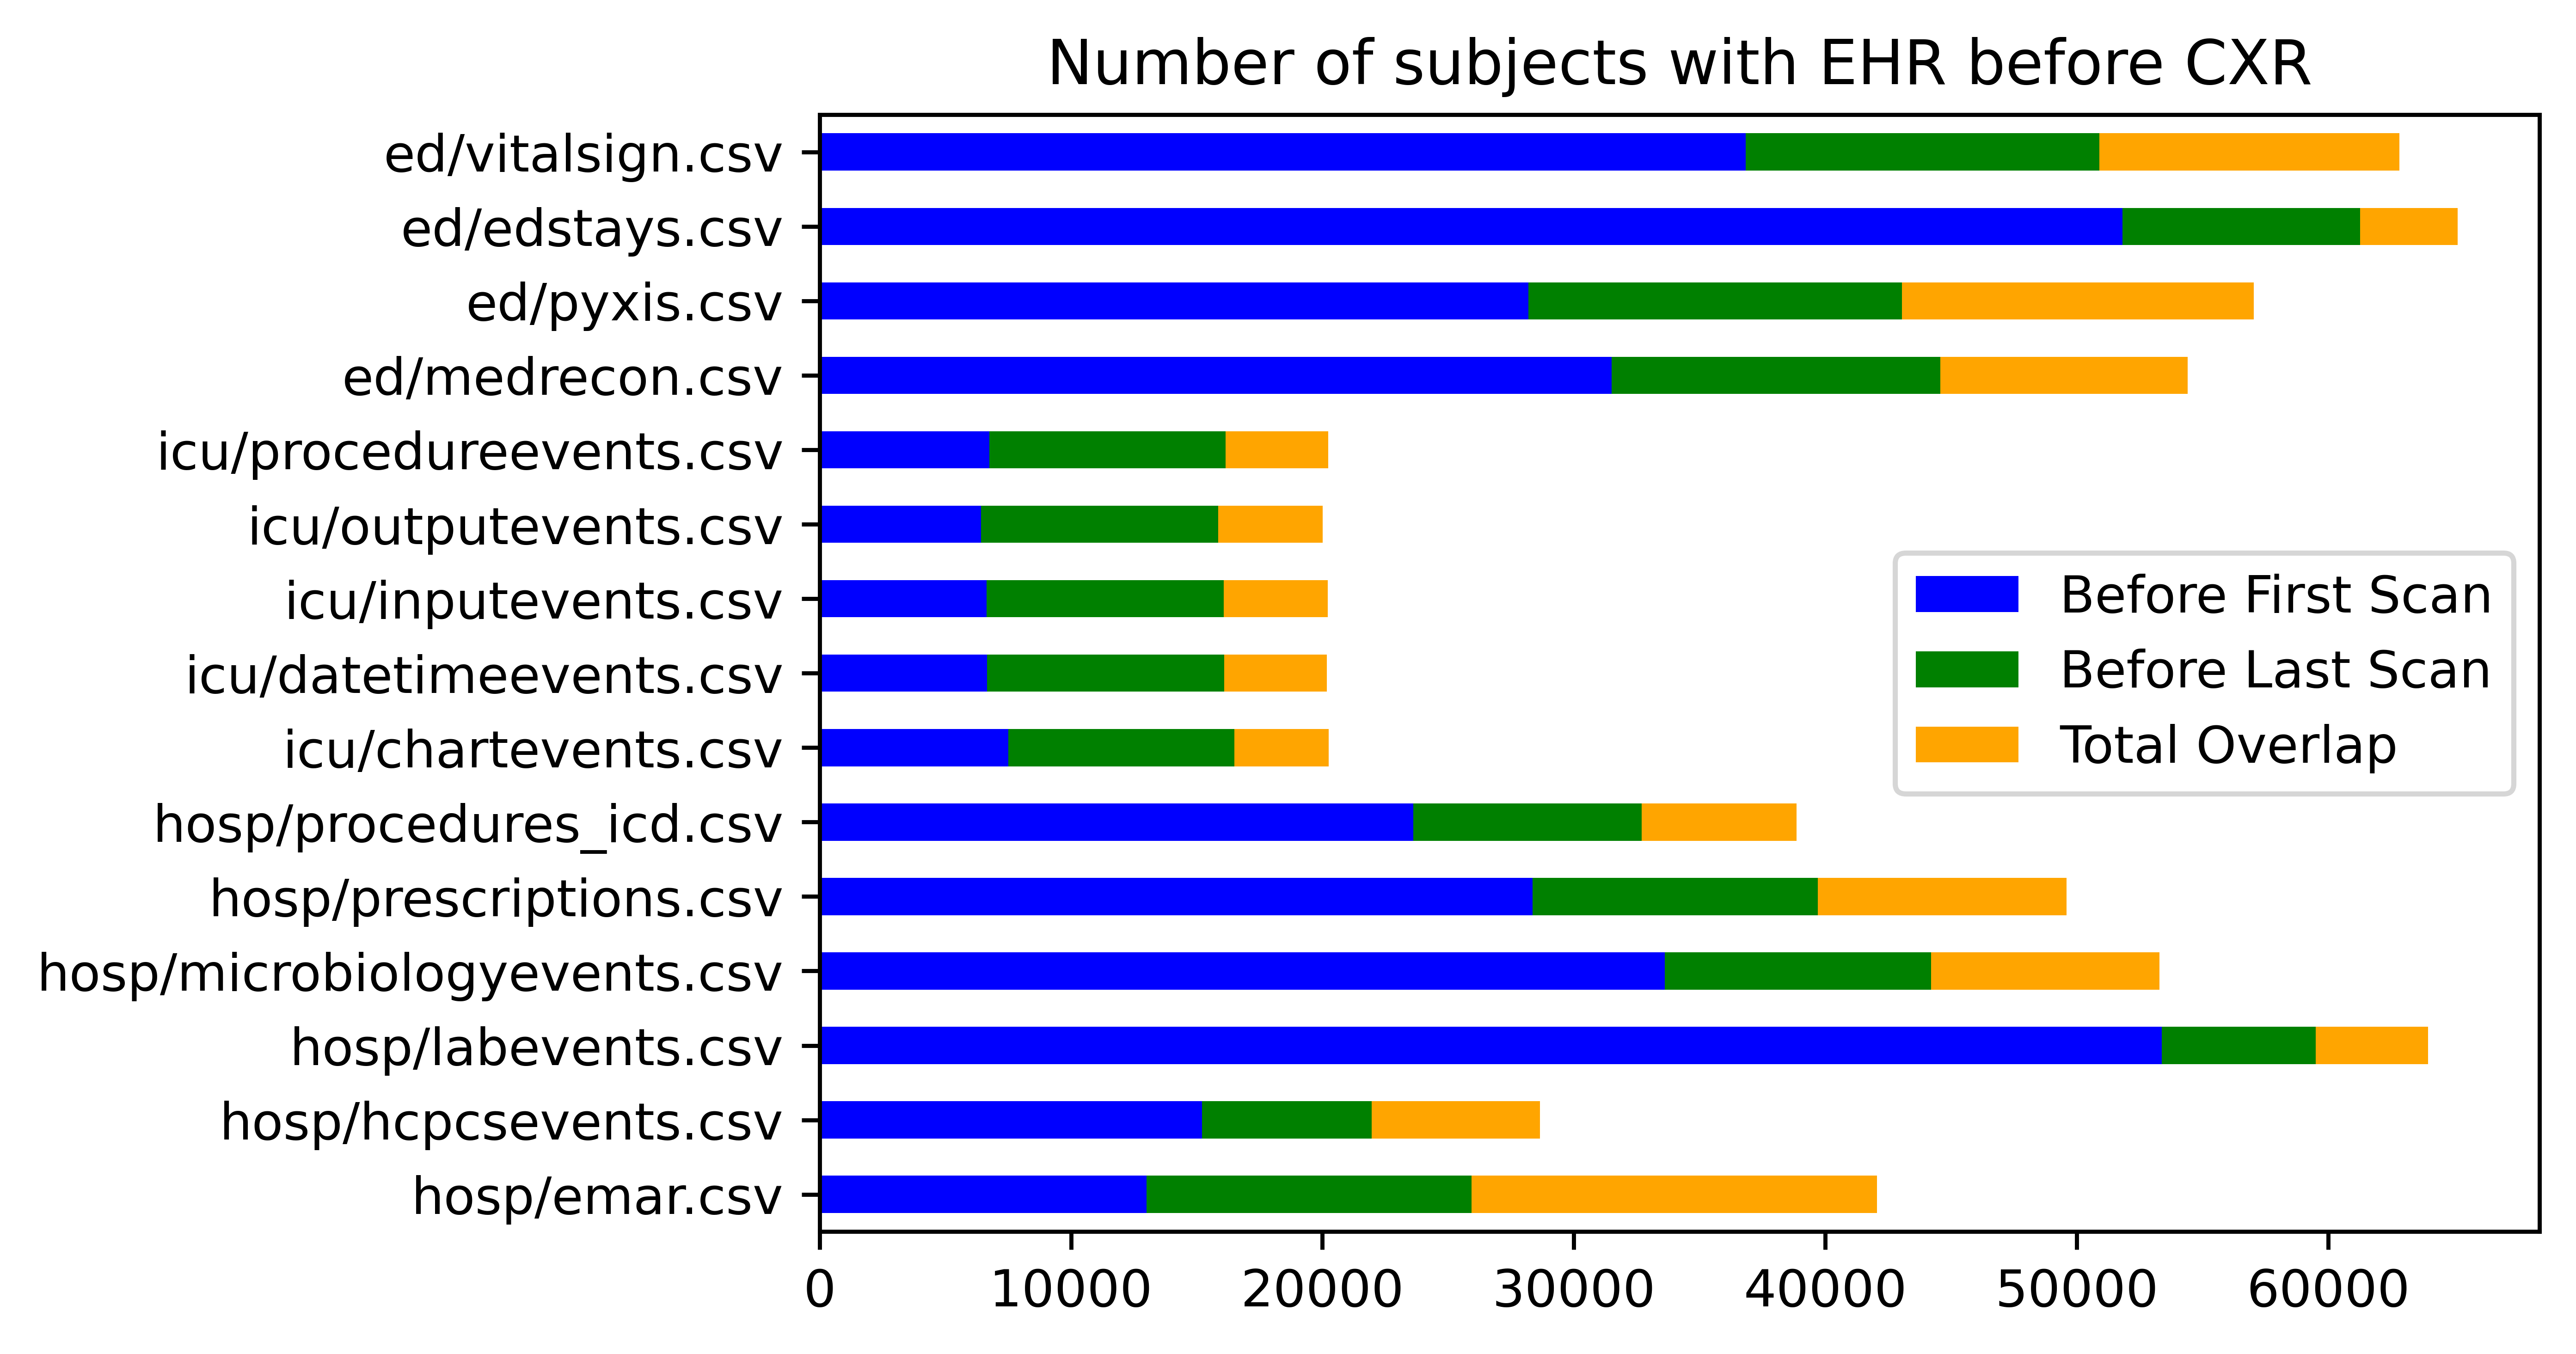

In [51]:
df_temp = pd.DataFrame.from_dict(time_check,'index')
df_temp = df_temp[df_temp.columns[[0,2]]].merge(pd.DataFrame.from_dict(overlap_count,'index',columns=['overlap_subject_count']),
                                                'left', left_index=True, right_index=True)
df_temp.overlap_subject_count = df_temp.overlap_subject_count - df_temp.overlapping_subject_count_last_scan
df_temp.overlapping_subject_count_last_scan = df_temp.overlapping_subject_count_last_scan - df_temp.overlapping_subject_count_first_scan
df_temp.columns = ['Before First Scan','Before Last Scan', 'Total Overlap']
plt.figure(dpi=800)
df_temp.plot.barh(stacked=True,title='Number of subjects with EHR before CXR',color=['blue','green','orange'],ax=plt.gca())
plt.show()